## Atividade 06
Utilizando os códigos mostrados durante a aula prática de arquiteturas Codificadoras-Decodificadoras, crie um Auto-Encoder para o dataset CIFAR-10. Lembre-se de alterar:

1- Dataset
2- DataLoader
3- Tamanho do código e taxa de aprendizado

Essa atividade demanda tempo, pois a cada modificação, é necessário observar o comportamento da rede. Não deixe para o último horário.

Faça um breve comentário explicando o que foi observado.

Envie o pdf do Notebook Jupyter ou similares com o código executado, os gráficos de treinamento para cada inicialização e as saídas.

# Dados

In [1]:
datasets_path = 'datasets'
tensorboard_path = 'ap6/Tensorboard'

## Dataloader

In [2]:
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def my_imshow(img):
    if img.shape[1] == 3 :    # RGB image
        img = img / 2 + 0.5     # unnormalize

    img = torchvision.utils.make_grid(img[:10],nrow=5)

    npimg = img.numpy()

    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg, interpolation='nearest')
    plt.axis('off')
    plt.show()

def show_images(train_loader, test_loader) :
    print('Train samples')
    # get some random training images
    dataiter = iter(train_loader)
    images = next(dataiter)[0]
    my_imshow(images)

    print('Test samples')
    # get some random training images
    dataiter = iter(test_loader)
    images = next(dataiter)[0]
    my_imshow(images)
    
##adicionar cifar 10 data loader
def get_data_cifar10 ( batch_size , show_image=False, numImages=10 ) :
  
    my_transform = torchvision.transforms.Compose([
                            torchvision.transforms.Resize(32), #resize para 32
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize(mean=[0.5],std=[0.5]) #na hora de testar tem que 
                                    ])                            #normalizar os dados dessa EXATA forma

    train_dataset = torchvision.datasets.CIFAR10(
                                root=f'{datasets_path}/train/', 
                                train=True, 
                                transform=my_transform, 
                                download=False
                                )
    test_dataset = torchvision.datasets.CIFAR10(
                                root=f'{datasets_path}/test/',
                                train=False, 
                                transform=my_transform, 
                                download=False
                                )
    train_loader = DataLoader(train_dataset, 
                                batch_size=batch_size,
                                shuffle=True
                                )
    test_loader = DataLoader(test_dataset, 
                            batch_size=batch_size,
                            shuffle=False
                            )
    
    if show_image :
        show_images(train_loader, test_loader)
    
    return train_loader, test_loader, len(train_dataset)
def get_data_mnist ( batch_size, show_image=False , seed=None) :

    my_transform = torchvision.transforms.Compose([
                                    torchvision.transforms.Resize(32),
                                    torchvision.transforms.ToTensor()
                                    ])

    train_dataset = torchvision.datasets.mnist.MNIST(
                                root=f'{datasets_path}/train/',
                                train=True,
                                download=False,
                                transform=my_transform
                                )
    test_dataset  = torchvision.datasets.mnist.MNIST(
                                root=f'{datasets_path}/test/',
                                train=False,
                                download=False,
                                transform=my_transform
                                )
    train_loader = DataLoader(train_dataset,
                                batch_size=batch_size,
                                shuffle=True
                                )
    test_loader  = DataLoader(test_dataset,
                                batch_size=batch_size,
                                shuffle=False
                                )

    if show_image :
        show_images(train_loader, test_loader)

    return train_loader, test_loader, len(train_dataset)

# Rede

## Arquitetura

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AE(nn.Module) :

  def __init__(self, code, in_channels=3):
    super().__init__()

    dim1 = 32
    dim2 = 64
    dim3 = 128
    code = code

    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=dim1, kernel_size=(4,4), stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=dim1, out_channels=dim2, kernel_size=(4,4), stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=dim2, out_channels=dim3, kernel_size=(4,4), stride=2, padding=1),
        nn.ReLU(),
    )

    #self.linear = nn.Sequential(
    #    nn.Flatten(),
    #    nn.Linear(in_features=64*4*4, out_features=code),
    #    nn.ReLU(),
    #    nn.Linear(in_features=code, out_features=64*4*4),
    #    nn.ReLU(),
    #    nn.Unflatten(dim=1, unflattened_size=(64, 4, 4))
    #)

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels=dim3, out_channels=dim2, kernel_size=(4,4), stride=2, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=dim2, out_channels=dim1, kernel_size=(4,4), stride=2, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=dim1, out_channels=in_channels, kernel_size=(4,4), stride=2, padding=1),
        nn.Sigmoid(),
    )

  def forward(self, x, debug=False):
    if debug : print('input',x.shape)
    y = self.encoder(x)
    if debug : print('enconder',y.shape)
    #y = self.linear(y)
    if debug : print('sequential',y.shape)
    y = self.decoder(y)
    if debug : print('decoder',y.shape)
    return y

## Inicialização

In [4]:
import math

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) :
        # Weights:
        # nn.init.constant_(m.weight.data, 0)
        # nn.init.constant_(m.weight.data, 1)
        # torch.nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('relu'))
        # torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        # torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

        # Bias:
        # nn.init.constant_(m.bias.data, 0)
        if m.bias is not None:
            fan_in, fan_out = nn.init._calculate_fan_in_and_fan_out(m.weight.data)
            bound = 1 / math.sqrt(fan_out)
            nn.init.normal_(m.bias, -bound, bound)

## Informações sobre a rede

In [5]:
from torchsummary import summary

if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")

print(f"Running on {my_device.type}.")

in_channel = 3
net = AE( code=100, in_channels=in_channel )

net = net.to(my_device)

a = torch.rand( (1, in_channel, 32 , 32) )
a = a.to(my_device)
b = net( a , debug=True )

Running on cuda.
input torch.Size([1, 3, 32, 32])
enconder torch.Size([1, 128, 4, 4])
sequential torch.Size([1, 128, 4, 4])
decoder torch.Size([1, 3, 32, 32])


In [6]:
summary(net, input_size=(in_channel,32,32), batch_size=32)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,568
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       32,832
|    └─ReLU: 2-4                         --
|    └─Conv2d: 2-5                       131,200
|    └─ReLU: 2-6                         --
├─Sequential: 1-2                        --
|    └─ConvTranspose2d: 2-7              131,136
|    └─ReLU: 2-8                         --
|    └─ConvTranspose2d: 2-9              32,800
|    └─ReLU: 2-10                        --
|    └─ConvTranspose2d: 2-11             1,539
|    └─Sigmoid: 2-12                     --
Total params: 331,075
Trainable params: 331,075
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,568
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       32,832
|    └─ReLU: 2-4                         --
|    └─Conv2d: 2-5                       131,200
|    └─ReLU: 2-6                         --
├─Sequential: 1-2                        --
|    └─ConvTranspose2d: 2-7              131,136
|    └─ReLU: 2-8                         --
|    └─ConvTranspose2d: 2-9              32,800
|    └─ReLU: 2-10                        --
|    └─ConvTranspose2d: 2-11             1,539
|    └─Sigmoid: 2-12                     --
Total params: 331,075
Trainable params: 331,075
Non-trainable params: 0

## Treinamento

In [7]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=.4):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [8]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import copy

def plot_layers( net , epoch, writer) :

    layers = list(net.encoder.modules())
    layer_id = 1
    for layer in layers:
        if isinstance(layer, nn.Conv2d) :

            writer.add_histogram('Encoder/Bias/conv{}'.format(layer_id),   layer.bias,        epoch)
            writer.add_histogram('Encoder/Weight/conv{}'.format(layer_id), layer.weight,      epoch)
            writer.add_histogram('Encoder/Grad/conv{}'.format(layer_id),   layer.weight.grad, epoch)
            layer_id += 1

    layers = list(net.decoder.modules())
    layer_id = 1
    for layer in layers:
        if isinstance(layer, nn.ConvTranspose2d) :

            writer.add_histogram('Decoder/Bias/upconv{}'.format(layer_id),   layer.bias,        epoch)
            writer.add_histogram('Decoder/Weight/upconv{}'.format(layer_id), layer.weight,      epoch)
            writer.add_histogram('Decoder/Grad/upconv{}'.format(layer_id),   layer.weight.grad, epoch)
            layer_id += 1

def train ( dataset='mnist', prefix=None, save=False, epochs=100, code=1024,
           lr=1e-5, device='cpu', debug=False, layers2tensorboard=False , image2tensorboard='True') :

    if dataset == 'mnist' :
        batch_size = 128
        train_loader, test_loader, dataset_size = get_data_mnist(batch_size, show_image=True)
        in_channels = 1
        criterion = nn.MSELoss()
    elif dataset == 'cifar10':
        batch_size = 128
        train_loader, test_loader, dataset_size = get_data_cifar10(batch_size, show_image=True)
        in_channels = 3
        criterion = nn.MSELoss()
    else :
        print('foi no treinamento')
        print('Error, dataloader is not implemented.')
        return None

    net = AE ( code=code, in_channels=in_channels )
    net.apply(init_weights)
    net.to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    now = datetime.now()
    suffix = now.strftime("%Y%m%d_%H%M%S")
    prefix = suffix if prefix is None else prefix + '-' + suffix

    writer = SummaryWriter( log_dir=tensorboard_path+prefix )

    losses = []
    smaller_loss = 1000.0

    add_noise = AddGaussianNoise()

    for epoch in range(epochs) :
        net.train()
        for idx, (train_x, _ ) in enumerate(train_loader):
            #train_noise_x = add_noise(train_x)
            #train_noise_x = train_noise_x.to(device)
            train_x = train_x.to(device)

            #predict_y = net( train_noise_x )
            predict_y = net( train_x )

            # Loss:
            error = criterion( predict_y , train_x )

            writer.add_scalar( 'Loss/train', error.item(), idx+( epoch*(dataset_size//batch_size) ) )

            # Back propagation
            optimizer.zero_grad()
            error.backward()
            optimizer.step()

            if debug and idx % 10 == 0 :
                print( 'idx: {}, _error: {}'.format( idx, error.item() ) )

        if layers2tensorboard :
            plot_layers( net , epoch, writer)

        loss_test = validate(net, test_loader, dataset, writer,
                             epoch, device=device, image2tensorboard=image2tensorboard)
        losses.append(loss_test)
        writer.add_scalar( 'Loss/test', loss_test, epoch )

        if loss_test < smaller_loss :
            best_model = copy.deepcopy(net)
            smaller_loss = loss_test
            print("Saving Best Model with Loss: ", loss_test)

        print( 'Epoch: {:3d} | Loss : {:3.4f}'.format(epoch+1, loss_test) )

    if save :
        path = '{}ae-mnist-{:.2f}.pkl'.format(models_path, smaller_loss)
        torch.save(best_model, path)
        print('Model saved in:',path)

    plt.plot(losses)

    writer.flush()
    writer.close()

    return best_model

## Validação

In [9]:
def validate ( model , data , dataset, writer, step, device='cpu', image2tensorboard=True) :

    model.eval()
    if dataset == 'mnist' :
        criterion = nn.MSELoss()
    elif dataset == 'cifar10' :
        criterion = nn.MSELoss()
    else :
        print('foi na validação')
        print('Error, dataloader is not implemented.')
        return None


    error = 0
    sum = 0
    num_images = 12

    add_noise = AddGaussianNoise()

    for idx, (test_x, _) in enumerate(data) :

        test_noise_x = add_noise(test_x)
        test_noise_x = test_noise_x.to(device)

        test_x = test_x.to(device)

        with torch.no_grad() :
            # predict_y = model( test_x ).detach()
            predict_y = model( test_noise_x ).detach()
        error_ = criterion( predict_y , test_x )
        error_ = error_.item()
        error = error + error_

        if idx == 1 :

            test_noise_x = test_noise_x.view(test_noise_x.size(0),
                                             test_noise_x.size(1),
                                             test_noise_x.size(2),
                                             test_noise_x.size(3)).cpu().data
            img_noise =  torchvision.utils.make_grid(test_noise_x[:num_images],
                                                        nrow=num_images//2)

            test_x = test_x.view(test_x.size(0),
                                             test_x.size(1),
                                             test_x.size(2),
                                             test_x.size(3)).cpu().data
            img_target =  torchvision.utils.make_grid(test_x[:num_images],
                                                        nrow=num_images//2)

            predict_y = predict_y.view(predict_y.size(0), predict_y.size(1), predict_y.size(2), predict_y.size(2)).cpu().data
            img_reconstructed = torchvision.utils.make_grid(predict_y[:num_images],nrow=num_images//2)


            print('Target')
            my_imshow(img_target)

            #print('Noise input')
            #my_imshow(img_noise)

            print('reconstructed')
            my_imshow(img_reconstructed)

        if image2tensorboard and idx == 1 :
            writer.add_image('Original_images', img_noise, step)
            writer.add_image('Reconstructed_images', img_reconstructed, step)

    return error/len(data)

# Execução

## Treina AE MNIST


Running on cuda.
Train samples


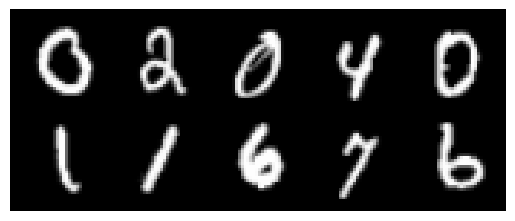

Test samples


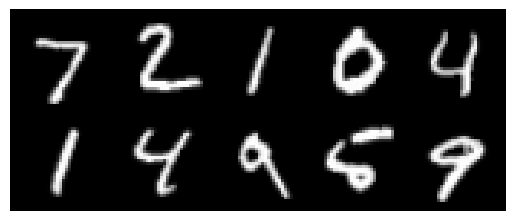

Target


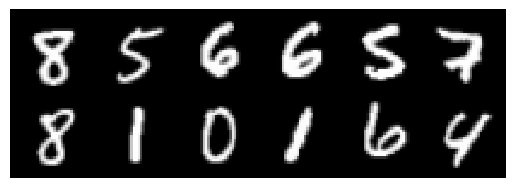

reconstructed


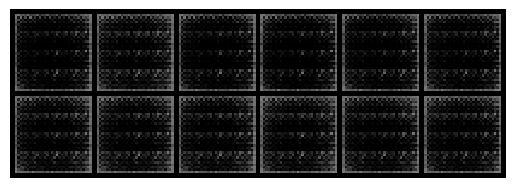

Saving Best Model with Loss:  0.11944362181651441
Epoch:   1 | Loss : 0.1194
Target


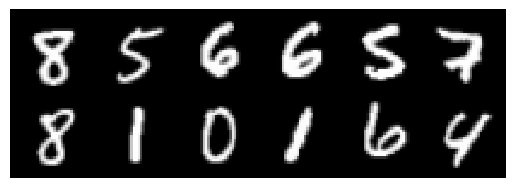

reconstructed


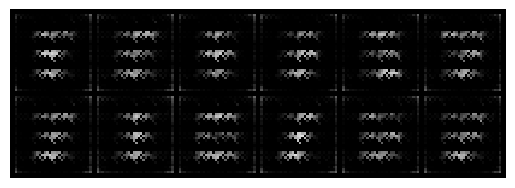

Saving Best Model with Loss:  0.0825203634987149
Epoch:   2 | Loss : 0.0825
Target


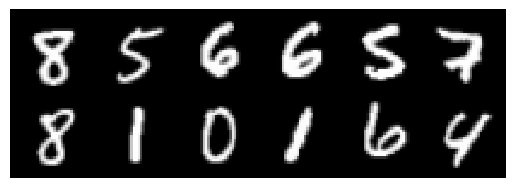

reconstructed


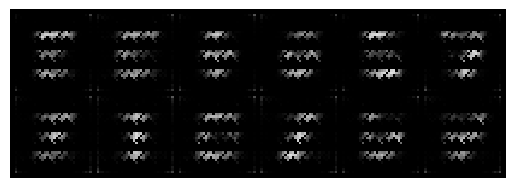

Saving Best Model with Loss:  0.07753966781723348
Epoch:   3 | Loss : 0.0775
Target


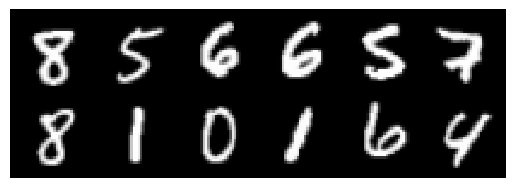

reconstructed


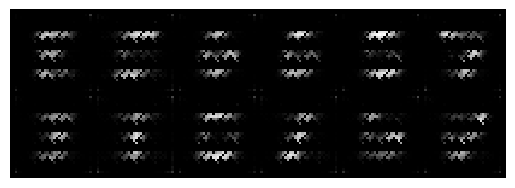

Saving Best Model with Loss:  0.07532492430904243
Epoch:   4 | Loss : 0.0753
Target


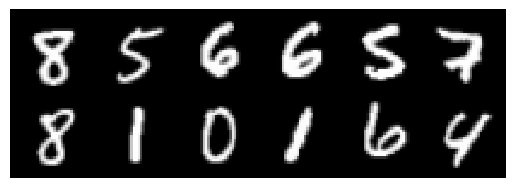

reconstructed


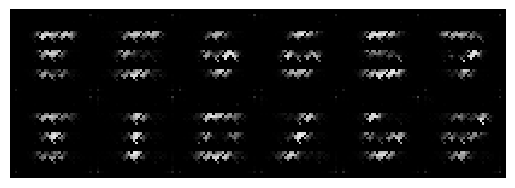

Saving Best Model with Loss:  0.07292272730530062
Epoch:   5 | Loss : 0.0729
Target


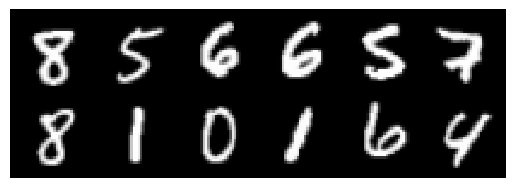

reconstructed


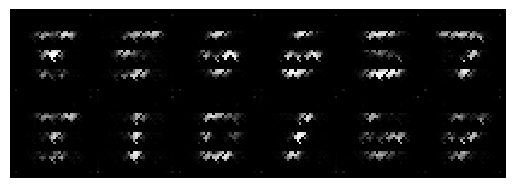

Saving Best Model with Loss:  0.07177116575686238
Epoch:   6 | Loss : 0.0718
Target


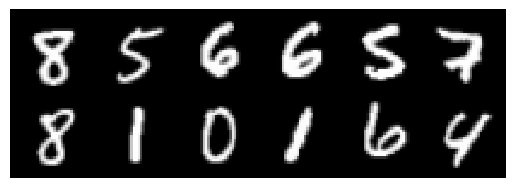

reconstructed


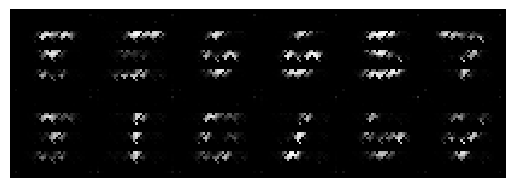

Saving Best Model with Loss:  0.070943525980545
Epoch:   7 | Loss : 0.0709
Target


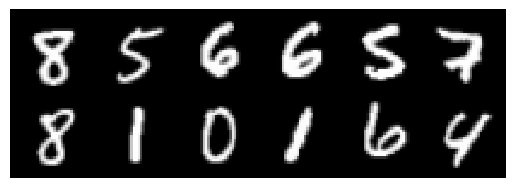

reconstructed


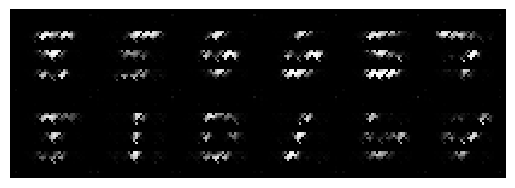

Saving Best Model with Loss:  0.07069910746775096
Epoch:   8 | Loss : 0.0707
Target


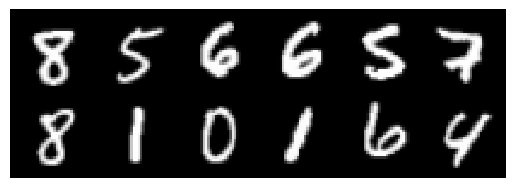

reconstructed


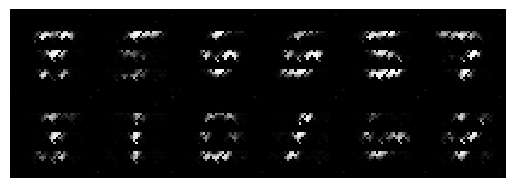

Saving Best Model with Loss:  0.07061904220830036
Epoch:   9 | Loss : 0.0706
Target


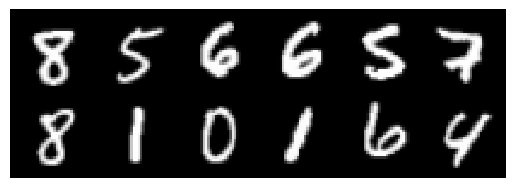

reconstructed


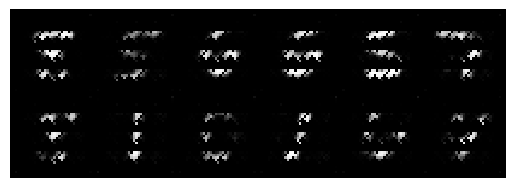

Saving Best Model with Loss:  0.0700972156151186
Epoch:  10 | Loss : 0.0701


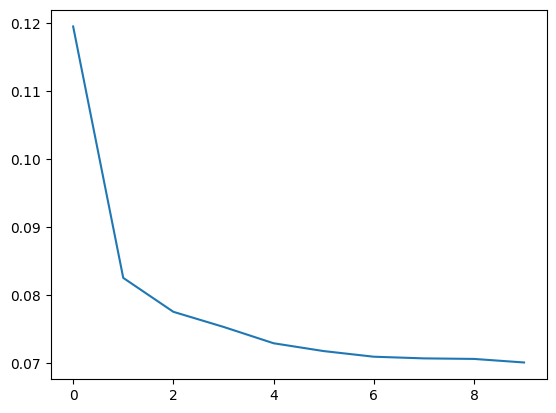

In [11]:
if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")

print(f"Running on {my_device.type}.")

epochs = 10
code = 64
prefix = 'AE-mnist'
dataset = 'mnist'
lr=1e-5

net_mnist = train(dataset=dataset, epochs=epochs, device=my_device, lr=lr, code=code,
            save=False, prefix=prefix, layers2tensorboard=False, image2tensorboard=True)

## Treina AE CIFAR-10


Running on cuda.
Train samples


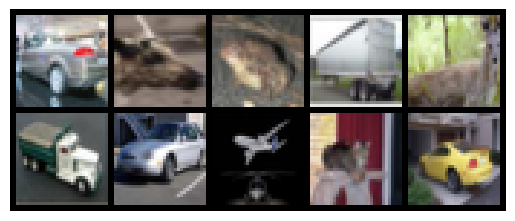

Test samples


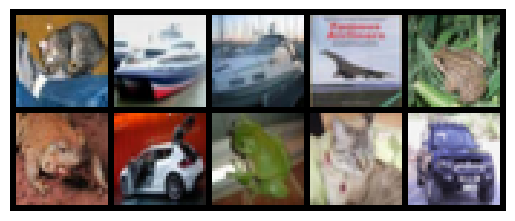

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target


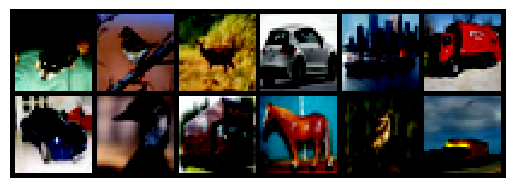

reconstructed


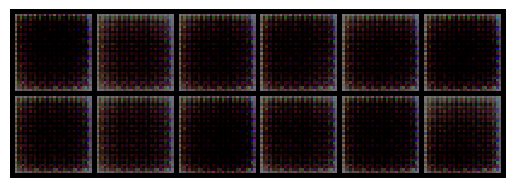

Saving Best Model with Loss:  0.2734263656260092
Epoch:   1 | Loss : 0.2734


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target


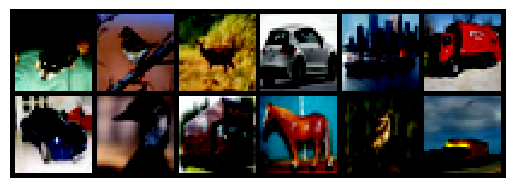

reconstructed


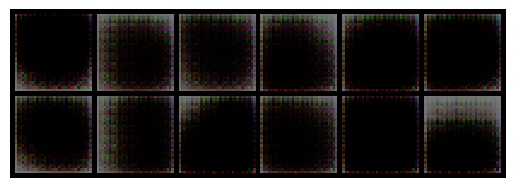

Saving Best Model with Loss:  0.23249076212508768
Epoch:   2 | Loss : 0.2325


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target


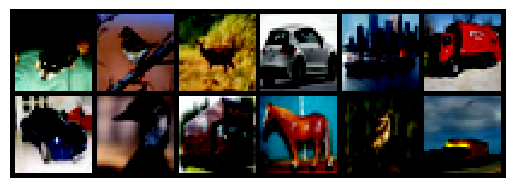

reconstructed


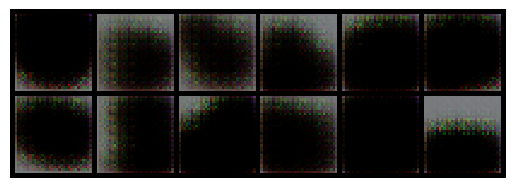

Saving Best Model with Loss:  0.21646708268908005
Epoch:   3 | Loss : 0.2165


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target


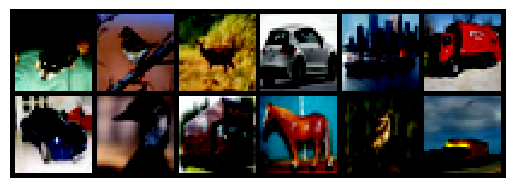

reconstructed


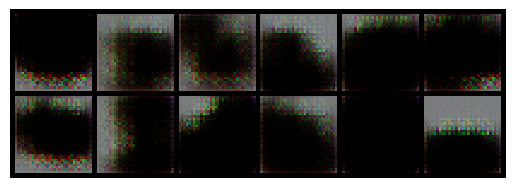

Saving Best Model with Loss:  0.2072965170763716
Epoch:   4 | Loss : 0.2073


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target


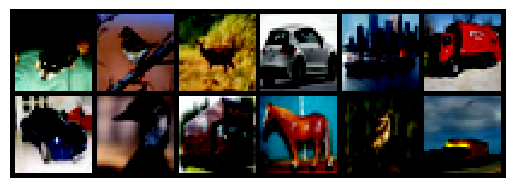

reconstructed


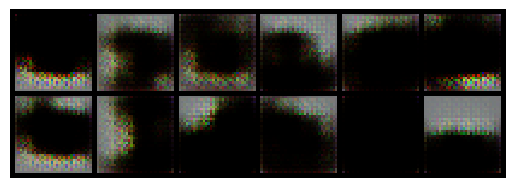

Saving Best Model with Loss:  0.1999949669536156
Epoch:   5 | Loss : 0.2000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target


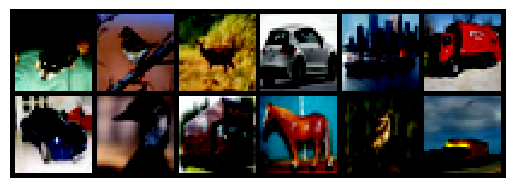

reconstructed


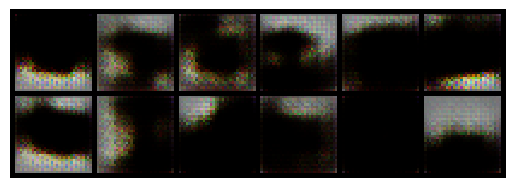

Saving Best Model with Loss:  0.19459504492675203
Epoch:   6 | Loss : 0.1946


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target


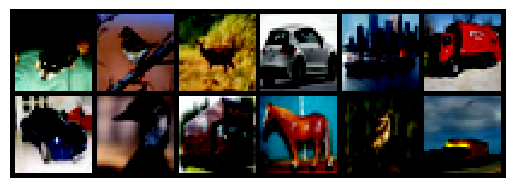

reconstructed


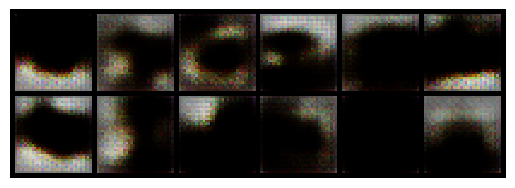

Saving Best Model with Loss:  0.18800945938388003
Epoch:   7 | Loss : 0.1880


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target


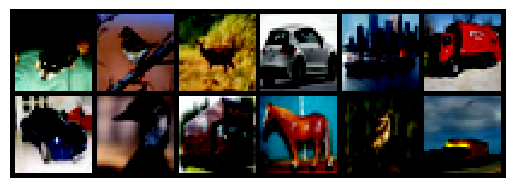

reconstructed


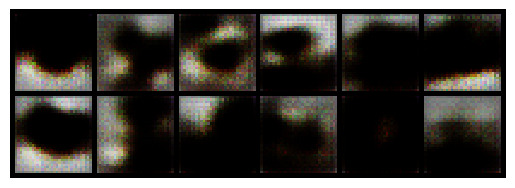

Saving Best Model with Loss:  0.1825069670058504
Epoch:   8 | Loss : 0.1825


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target


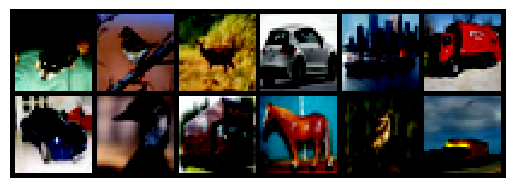

reconstructed


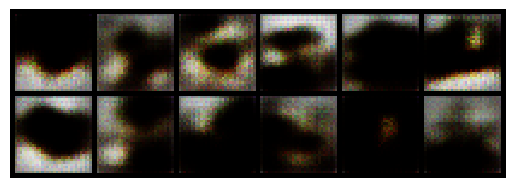

Saving Best Model with Loss:  0.17786380893821957
Epoch:   9 | Loss : 0.1779


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target


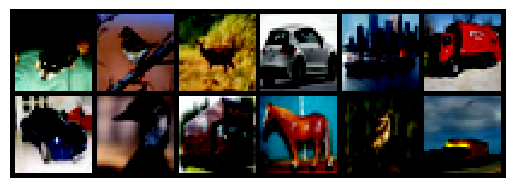

reconstructed


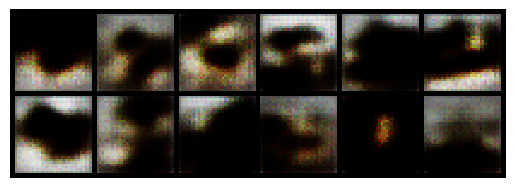

Saving Best Model with Loss:  0.1747763749164871
Epoch:  10 | Loss : 0.1748


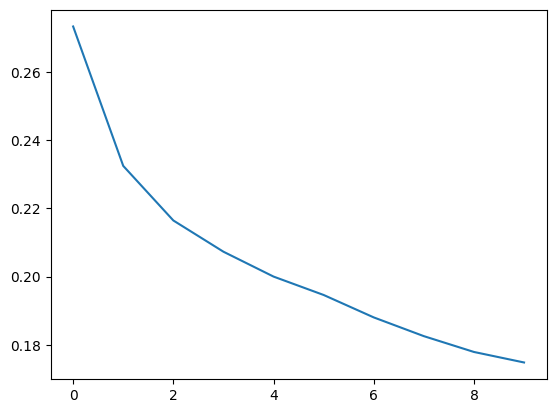

In [12]:
if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")

print(f"Running on {my_device.type}.")

epochs = 10
code = 1024
prefix = 'AE-cifar10'
dataset = 'cifar10'
lr=1e-5

net_cifar10 = train(dataset=dataset, epochs=epochs, device=my_device, lr=lr, code=code,
            save=False, prefix=prefix, layers2tensorboard=False, image2tensorboard=True)

## Conclusão
O cifar-10 precisa de um código de representação maior para que o MNIST, visto que as fotos do cifar-10 são maiores por serem coloridas e por isso a loss não chega a ser tão baixa como no auto encoder do MNIST, usando o mesmo learning rate.

# Teste

In [ ]:
def test_image_reconstruction(dataset, net, device, num_images=10):

    if dataset == 'mnist' :
        test_loader = get_data_mnist(batch_size=32)[1]
    elif dataset == 'cifar10' :
        test_loader = get_data_cifar10(batch_size=32)[1]

    else :
        print('Error, dataloader is not implemented.')
        return None


    img = next(iter(test_loader))[0]
    # img_noise = img.to(device)

    add_noise = AddGaussianNoise()
    img_noise = add_noise(img)
    img_noise = img_noise.to(device)

    net.eval()
    with torch.no_grad():
        outputs = net( img_noise )

    print("Originals")
    img_noise = img_noise.view(img_noise.size(0),
                                    img_noise.size(1),
                                    img_noise.size(2),
                                    img_noise.size(3)).cpu().data
    my_imshow(torchvision.utils.make_grid(img_noise[:num_images],
                                          nrow=num_images//2))

    print("Reconstructed")
    outputs = outputs.view(outputs.size(0),
                                    outputs.size(1),
                                    outputs.size(2),
                                    outputs.size(3)).cpu().data
    my_imshow(torchvision.utils.make_grid(outputs[:num_images],
                                          nrow=num_images//2))

In [ ]:
test_image_reconstruction(dataset, net_mnist, my_device, 20)